# Regresión Espacial

La regresión proporciona un caso perfecto para examinar cómo la estructura espacial puede ayudar a comprender y analizar los datos. En este taller, se analiza cómo se puede utilizar la estructura espacial para validar y mejorar los algoritmos de predicción, centrándose específicamente en la regresión lineal.

## *¿Qué* es la regresión espacial y *por qué* podría ser importante?

Por lo general, la estructura espacial ayuda a los modelos de regresión de dos maneras.

La primera forma en la que el espacio puede tener un impacto en los datos es cuando el proceso *que genera* los datos es en sí mismo explícitamente espacial. Se puede pensar en algo así como los precios de las viviendas unifamiliares. A menudo ocurre que las personas pagan una prima sobre el precio de su casa para poder vivir en un mejor distrito escolar por una casa de la misma calidad. Alternativamente, las casas más cercanas a contaminantes acústicos o químicos, como plantas de tratamiento de aguas residuales, instalaciones de reciclaje o autopistas anchas, pueden en realidad ser más baratas de lo que se anticiparía.

Independientemente del caso específico en juego, aquí la *geografía es una característica* dado que ayuda directamente a hacer predicciones sobre los resultados *porque esos resultados se obtienen a partir de procesos geográficos*.

Otra alternativa para incluir información en el análisis de métodos predictivos y clasificadores, a un analista le puede preocupar que el modelo prediga erróneamente *sistemáticamente* algunos tipos de observaciones. Si se sabe que el modelo rutinariamente funciona mal en un conjunto de observaciones, se podría hacer un modelo mejor si se puede identificar esto. 

 La geografía proporciona una incorporación excepcionalmente útil para evaluar la estructura de nuestros errores. Graficar los errores de clasificación/predicción en un mapa puede ayudar a mostrar si hay o no *grupos de errores* en los datos. Si *se sabe* que los errores tienden a ser mayores en algunas áreas que en otras (o si el error es "contagioso" entre observaciones), entonces se podría explotar esta estructura para hacer mejores predicciones.

La estructura espacial en nuestros errores puede surgir cuando la geografía *debería ser* un atributo de alguna manera, pero no se está seguro exactamente de cómo incluirla en el modelo. También podrían surgir porque hay alguna *otra* característica cuya omisión causa los patrones espaciales en el error que se observa, si se incluyera esta característica adicional, la estructura desaparecería.

O podría surgir de las complejas interacciones e interdependencias entre las características que se han elegido como predictores, lo que da como resultado una estructura intrínseca en la predicción errónea.  La mayoría de los predictores que se utilizan en modelos de procesos sociales contienen información espacial *incorporada*: patrones intrínsecos a la característica que obtenemos de forma gratuita en el modelo.

Si se pretende o no, el uso de un predictor con patrones espaciales en un modelo puede dar como resultado errores con patrones espaciales, usar más de uno puede amplificar este efecto. 
Por lo tanto, *independientemente de si el verdadero proceso es explícitamente geográfico o no*, información adicional sobre las relaciones espaciales entre las observaciones o más información sobre sitios cercanos puede mejorar las predicciones.

En este taller, se incorpora el espacio al marco de regresión tradicional. Se comienza con un modelo de regresión lineal estándar, desprovisto de cualquier referencia geográfica. A partir de ahí, se formaliza el espacio y las relaciones espaciales de tres maneras principales: primero, codificándolo en variables exógenas, en segundo lugar, a través de la heterogeneidad espacial o como una variación sistemática de los resultados en el espacio, tercero, como dependencia, o mediante el efecto asociado a las características de los vecinos espaciales. En todo momento, centrándose en las diferencias conceptuales que implica cada enfoque más que en los detalles técnicos.

## Regresión clásica (no espacial), un repaso muy rápido

Antes de discutir cómo incluir explícitamente el espacio en el marco de regresión lineal, se muestra cómo se puede llevar a cabo la regresión básica en Python y cómo se pueden comenzar a interpretar los resultados.

La idea central de la regresión lineal es explicar la variación en una variable dada (*dependiente*) como una función lineal de un conjunto de otras variables (*explicatorias*). Por ejemplo, en este caso, se puede querer expresar el precio de una casa en función del número de dormitorios que tiene y de si es condominio o no. A nivel individual, se puede expresar esto como:

$$
y_i = \alpha + \sum_k \beta_k \mathbf{X}_{ik}  + \epsilon_i
$$

Por ejemplo, en este caso, se puede querer expresar el precio de una casa en función del número de dormitorios que tiene y de si es condominio o no. A nivel individual, se puede expresar esto como:

$$
P_i = \alpha + \sum_k \beta_k \mathbf{X}_{ik}  + \epsilon_i
$$

donde $P_i$ es el precio de Airbnb de la casa $i$, y $X$ es un conjunto de covariables que se usan para explicar dicho precio (por ejemplo, cantidad de habitaciones y variable binaria de condominio). $\beta$ es un vector de parámetros que nos dan información sobre de qué manera y en qué medida cada variable está relacionada con el precio, y $\alpha$, el término constante, es el precio medio de la vivienda cuando todas las demás variables son cero. El término $\epsilon_i$ generalmente se conoce como "error" y captura elementos que influyen en el precio de una casa pero que no están incluidos en $X$.

El objetivo cuando se entrena un modelo de regresión es estimar los parámetros $\alpha$ y $\beta_k$ para predecir los valores de $y$

En la práctica, existen varios paquetes en Python que permiten entrenar modelos de regresión, algunos de estos son:  `statsmodels`, `scikit-learn` y `pysal`.

## Dataset: San Diego Airbnb

En este taller se examinará información sobre propiedades de Airbnb en San Diego, California en Estados Unidos. Este conjunto de datos se basa en el extracto de San Diego del 2024-03-25 de [Inside Airbnb](http://insideairbnb.com/).

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path().cwd().parent.parent.absolute() / "data/airbnb"

### Listado de propiedades:

In [2]:
# Listings

url = "https://data.insideairbnb.com/united-states/"\
    "ca/san-diego/2024-03-25/data/listings.csv.gz"

listings_path = DATA_PATH / "listings.csv.gz"

response = requests.get(url)

with open(listings_path, "wb") as file:
    file.write(response.content)

### Vecindarios

In [3]:
# Neighbourhoods

url =  "https://data.insideairbnb.com/united-states/"\
    "ca/san-diego/2024-03-25/visualisations/neighbourhoods.geojson"

neighbourhoods_path = DATA_PATH / "neighbourhoods.geojson"

response = requests.get(url)

with open(neighbourhoods_path, "wb") as file:
    file.write(response.content)

#### Feature engineering

In [4]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
listings = pd.read_csv(listings_path)

In [6]:
listings.shape

(11496, 75)

#### Columnas de interés:

* accommodates: Cantidad de personas que puede acoger
* amenities: Comodidades que ofrece el alojamiento
* bathrooms: Cantidad de baños
* bedrooms: Cantidad de cuantos
* beds: Cantidad de camas disponibles
* latitude: Latitud
* Longitude: Longitud
* neighbourhood_cleansed: Vecindario
* price: Precio del alojamiento (variable objetivo)
* room_type: Tipo de habitación

In [7]:
listings = listings[
    [
        "accommodates",
        "amenities",
        "bathrooms",
        "beds",
        "latitude",
        "longitude",
        "neighbourhood_cleansed",
        "price",
    ]
].rename(columns={"neighbourhood_cleansed": "neighbourhood"})

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11496 entries, 0 to 11495
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   accommodates   11496 non-null  int64  
 1   amenities      11496 non-null  object 
 2   bathrooms      11229 non-null  float64
 3   beds           11203 non-null  float64
 4   latitude       11496 non-null  float64
 5   longitude      11496 non-null  float64
 6   neighbourhood  11496 non-null  object 
 7   price          11230 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 718.6+ KB


#### Variable objetivo: Precio

In [8]:
listings["price"].head(10)

0    $274.00
1    $231.00
2    $163.00
3     $87.00
4    $102.00
5    $179.00
6     $71.00
7    $226.00
8    $914.00
9    $811.00
Name: price, dtype: object

In [9]:
listings["price"] = listings["price"].str.lstrip("$").str.replace(",", "").astype(float)

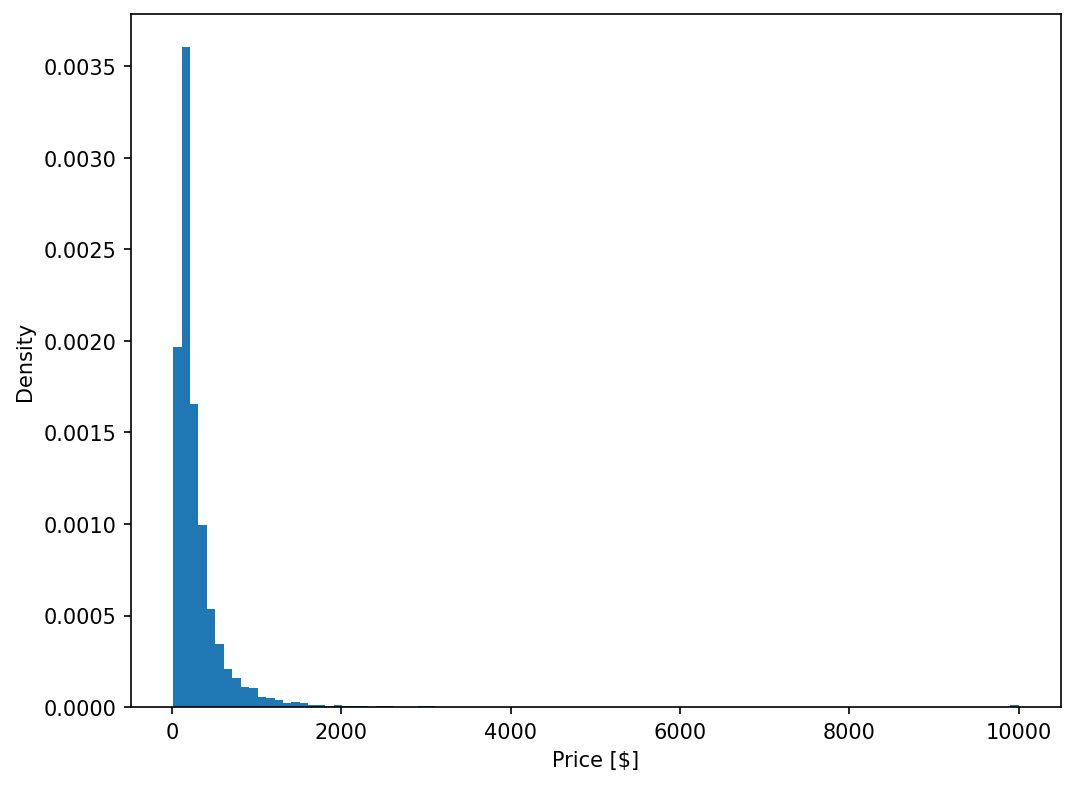

In [10]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist(listings["price"], density=True, bins=100)
ax.set(
    ylabel="Density",
    xlabel="Price [$]"
)
plt.show()

En Machine Learning, se suelen transformar las variables para normalizar datos, reducir el impacto de valores atípicos y hacer que los datos sean más adecuados para ciertos tipos de análisis. En este caso, se aplica una transformación logarítmica para reducir la escala del precio.

In [11]:
listings["log_price"] = np.log(listings["price"])

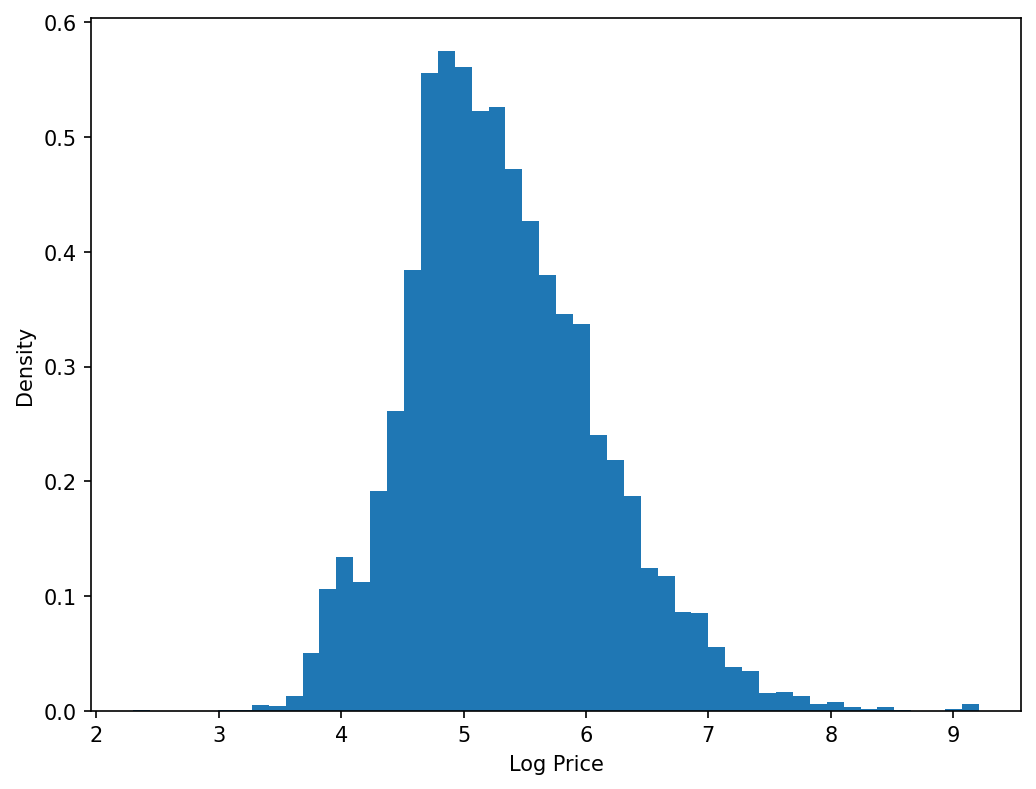

In [12]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist(listings["log_price"], density=True, bins=50)
ax.set(
    ylabel="Density",
    xlabel="Log Price"
)
plt.show()

#### Amenities: ¿Tiene lavaplatos / lavavajillas?

In [13]:
for amenity in listings["amenities"].unique()[:1]:
    print(amenity)

["Free dryer \u2013 In unit", "Cooking basics", "Children\u2019s dinnerware", "Laundromat nearby", "Oven", "Coffee", "Ethernet connection", "Fire pit", "Baby monitor", "Blender", "Children's playroom", "Wine glasses", "Private backyard \u2013 Fully fenced", "Central air conditioning", "Dishes and silverware", "Private entrance", "Bed linens", "Smoke alarm", "Coffee maker: Keurig coffee machine, pour-over coffee", "Toaster", "Wifi", "Free parking on premises", "Ceiling fan", "Luggage dropoff allowed", "Cleaning products", "Shower gel", "Children\u2019s bikes", "Portable fans", "Extra pillows and blankets", "Children\u2019s books and toys", "Self check-in", "Essentials", "Iron", "Microwave", "First aid kit", "75\" HDTV with Amazon Prime Video, Apple TV, Disney+, HBO Max, Hulu, Netflix", "Pack \u2019n play/Travel crib - available upon request", "Dishwasher", "Freezer", "Heating", "Hot water", "Barbecue utensils", "Bathtub", "Hair dryer", "Books and reading material", "Pets allowed", "Crib

In [14]:
# Convert string in lists
listings["amenities"] = listings["amenities"].apply(json.loads)

In [15]:
listings["amenities"][0]

['Free dryer – In unit',
 'Cooking basics',
 'Children’s dinnerware',
 'Laundromat nearby',
 'Oven',
 'Coffee',
 'Ethernet connection',
 'Fire pit',
 'Baby monitor',
 'Blender',
 "Children's playroom",
 'Wine glasses',
 'Private backyard – Fully fenced',
 'Central air conditioning',
 'Dishes and silverware',
 'Private entrance',
 'Bed linens',
 'Smoke alarm',
 'Coffee maker: Keurig coffee machine, pour-over coffee',
 'Toaster',
 'Wifi',
 'Free parking on premises',
 'Ceiling fan',
 'Luggage dropoff allowed',
 'Cleaning products',
 'Shower gel',
 'Children’s bikes',
 'Portable fans',
 'Extra pillows and blankets',
 'Children’s books and toys',
 'Self check-in',
 'Essentials',
 'Iron',
 'Microwave',
 'First aid kit',
 '75" HDTV with Amazon Prime Video, Apple TV, Disney+, HBO Max, Hulu, Netflix',
 'Pack ’n play/Travel crib - available upon request',
 'Dishwasher',
 'Freezer',
 'Heating',
 'Hot water',
 'Barbecue utensils',
 'Bathtub',
 'Hair dryer',
 'Books and reading material',
 'Pets a

In [16]:
listings["has_dishwasher"] = listings["amenities"].apply(
    lambda x: any("dishwasher" in amenity.lower() for amenity in x)
).astype(int)

In [17]:
print(f"Number of properties with dishwaher: {listings['has_dishwasher'].sum()}")

Number of properties with dishwaher: 6509


In [18]:
listings["has_dishwasher"].mean()

0.566196938065414

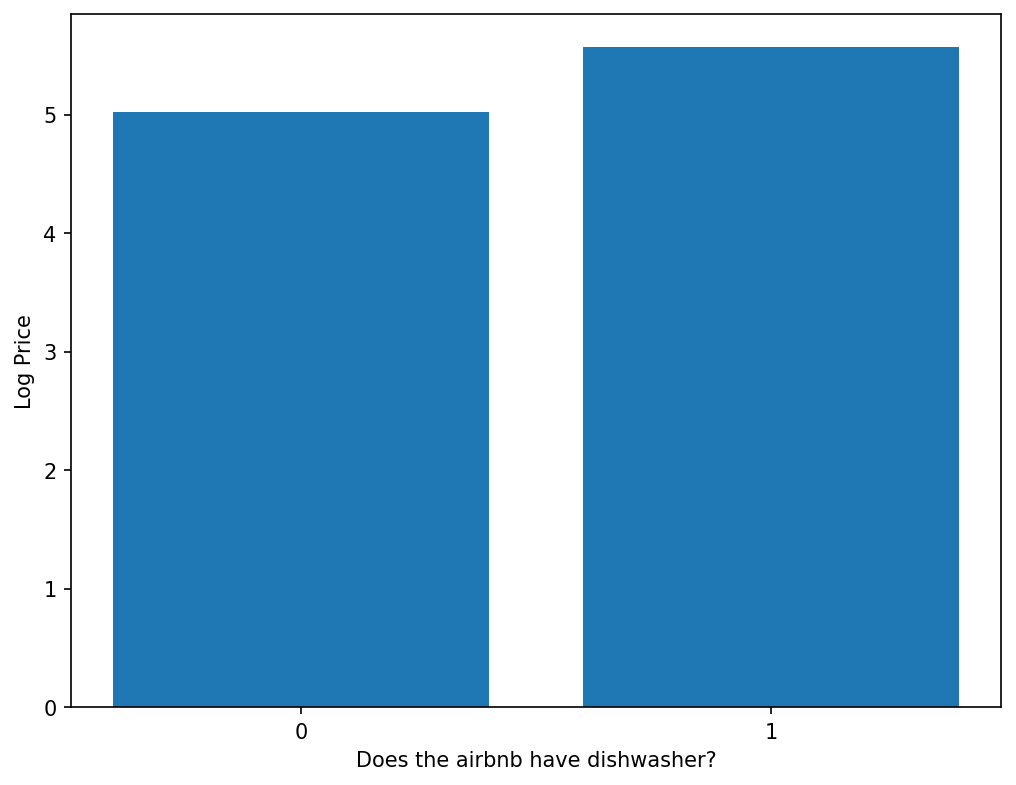

In [19]:
# Average price
avg_price = listings.groupby("has_dishwasher")["log_price"].mean().reset_index()

has_dishwasher = avg_price["has_dishwasher"]
prices = avg_price["log_price"]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Crear el gráfico de barras en los ejes
ax.bar(has_dishwasher, prices)

# Agregar título y etiquetas
ax.set_xlabel("Does the airbnb have dishwasher?")
ax.set_ylabel("Log Price")
ax.set_xticks(has_dishwasher, [0, 1])

plt.show()

#### Filtrar observaciones con nulls o valores erróneos

In [20]:
listings = listings.dropna()

listings = listings[(listings["bathrooms"] >= 1)&(listings["beds"] >= 1)]

#### Filtrar vecindarios con pocas observaciones

Los vecindarios con pocos datos pueden no proporcionar estadísticas confiables. Con más de 25 datos, es más probable que los estadísticos sean representativos.

In [21]:
neighborhood_counts = listings["neighbourhood"].value_counts()
neighborhoods_to_keep = neighborhood_counts[neighborhood_counts > 25].index

listings = listings[
    listings["neighbourhood"].isin(
        neighborhoods_to_keep
    )
].reset_index(drop=True)

listings.shape

(10299, 10)

In [22]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   accommodates    10299 non-null  int64  
 1   amenities       10299 non-null  object 
 2   bathrooms       10299 non-null  float64
 3   beds            10299 non-null  float64
 4   latitude        10299 non-null  float64
 5   longitude       10299 non-null  float64
 6   neighbourhood   10299 non-null  object 
 7   price           10299 non-null  float64
 8   log_price       10299 non-null  float64
 9   has_dishwasher  10299 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 804.7+ KB


### Primer modelo de regresión

 En este taller se hace uso del módulo `spreg` en Pysal. En el contexto de este taller, tiene sentido empezar con `spreg`, ya que es la única librería que permitirá avanzar hacia modelos espaciales.

In [23]:
from pysal.model import spreg

In [24]:
variables = [
    "accommodates",
    "bathrooms",
    "beds",
    # Binary variables, 1 True, 0 False
    "has_dishwasher",
]

y = listings["log_price"]

X = listings[variables]
X.head()

,accommodates,bathrooms,beds,has_dishwasher
0,6,2.0,3.0,1
1,6,2.0,3.0,0
2,2,1.0,6.0,1
3,2,1.0,1.0,0
4,2,1.0,2.0,0


Para ajustar el modelo usando mínimos cuadrados ordinarios (OLS), sólo se necesita la siguiente línea de código.

Es importante mencionar que los objectos necesitan ser arrays, por lo que lo que se extrae usando el atributo `values`.

In [25]:
# Fit OLS model
model_1 = spreg.OLS(
    y.values,
    X.values,
    name_y="log_price",
    name_x=variables,
)

Para inspeccionar los resultados del modelo, se puede hacer un print el atributo `summary`:

In [26]:
print(model_1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       10299
Mean dependent var  :      5.3571                Number of Variables   :           5
S.D. dependent var  :      0.7811                Degrees of Freedom    :       10294
R-squared           :      0.5538
Adjusted R-squared  :      0.5536
Sum squared residual:     2803.05                F-statistic           :   3194.3799
Sigma-square        :       0.272                Prob(F-statistic)     :           0
S.E. of regression  :       0.522                Log likelihood        :   -7912.399
Sigma-square ML     :       0.272                Akaike info criterion :   15834.798
S.E of regression ML:      0.5217                Schwarz criterion     :   15870.997

------------------------------------------------------------

De este resultado, es importante concentrarse en la sección `Coefficients`, que brinda las estimaciones de $\beta_k$ en el modelo. En otras palabras, estos números expresan la relación entre cada variable explicativa y la dependiente.

Los resultados son en gran medida los esperados: las casas tienden a ser significativamente más caras si tienen capacidad para más personas (`accommodates`), si tienen más baños y dormitorios. Por el contrario, dado el número de habitaciones, las casas con más camas (es decir, las que están más "pobladas") tienden a ser más baratas.

### Estructuras ocultas

En general, el modelo puede predecir alrededor de la mitad ($R^2=0,55$) de la variación en el precio medio nocturno utilizando las covariables que se han analizado anteriormente.

Sin embargo, el modelo puede mostrar cierta agrupación en los errores, lo que puede ser un problema ya que viola la norma i.i.d. que los modelos lineales de suposición generalmente vienen incorporados.

Para evaluar esto, se pueden hacer algunas cosas.

Un concepto sencillo podría ser observar la correlación entre el error al predecir un Airbnb y el error al predecir su vecino más cercano. Para examinar esto, primero se podría dividir los datos por regiones y ver si se tiene alguna estructura espacial en los residuos.

Una teoría razonable podría ser que el modelo no incluye ninguna información sobre *playas*, un aspecto crítico de por qué la gente vive y vacaciona en San Diego. Por lo tanto, es posible que se desee ver si los errores son mayores o menores dependiendo de si un Airbnb está o no en un vecindario "de playa", un vecindario cerca del océano.

In [27]:
listings.columns

Index(['accommodates', 'amenities', 'bathrooms', 'beds', 'latitude',
       'longitude', 'neighbourhood', 'price', 'log_price', 'has_dishwasher'],
      dtype='object')

In [28]:
coastal_neighborhoods = [
    "Wooded Area",
    "Ocean Beach",
    "Pacific Beach",
    "La Jolla",
    "Torrey Pines",
    "Del Mar Heighs",
    "Mission Bay",
]

# Create a Boolean (True/False) with whether a property is coastal or not
listings["is_coastal_neig"] = (
    listings["neighbourhood"].isin(coastal_neighborhoods).astype(bool)
)


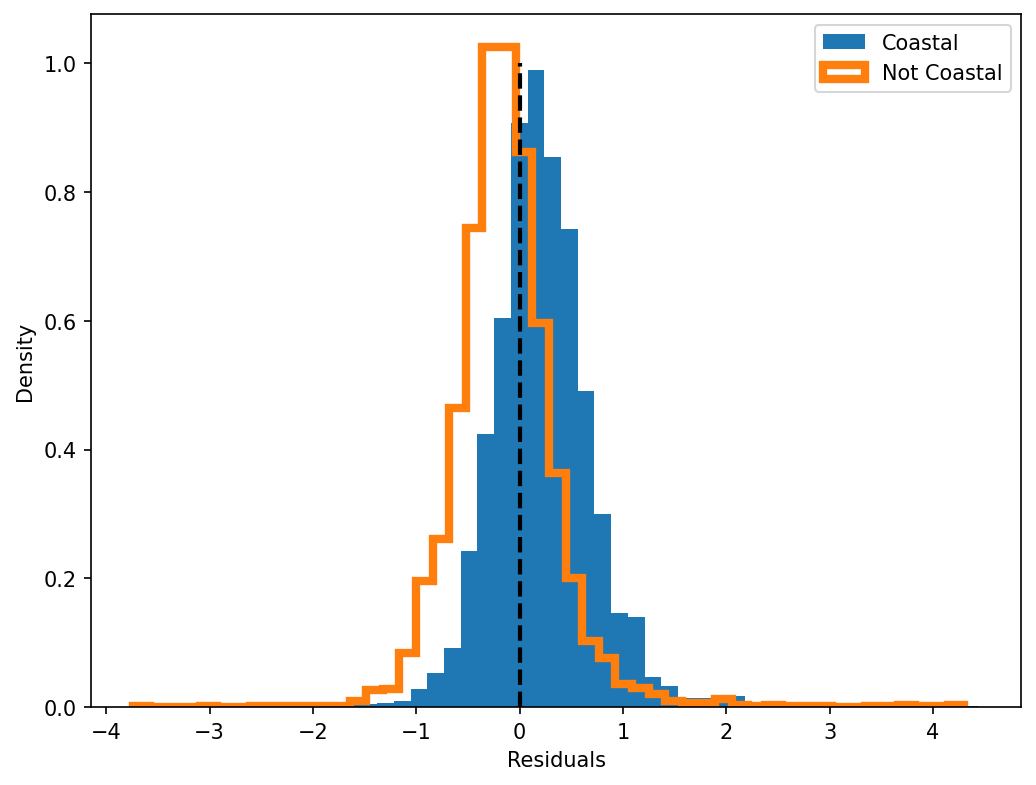

In [29]:
is_coastal_neig = listings["is_coastal_neig"].astype(bool)

# Split residuals between coastal and not
coastal_residuals = model_1.u[is_coastal_neig]
non_coastal_residuals = model_1.u[~is_coastal_neig]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Create histogram of the distribution of coastal and non-coastal residuals
ax.hist(coastal_residuals, density=True, bins=50, label="Coastal")
ax.hist(
    non_coastal_residuals,
    histtype="step",
    density=True,
    linewidth=4,
    bins=50,
    label="Not Coastal",
)
ax.set(ylabel="Density", xlabel="Residuals")

# Add Line on 0
plt.vlines(0, 0, 1, linestyle="--", color="k", linewidth=2)
# Add legend
plt.legend()
# Display
plt.show()

Si bien parece que los vecindarios de la costa tienen errores promedio sólo ligeramente más altos, las dos distribuciones son significativamente distintas entre sí cuando se comparan utilizando una prueba $t$ clásica:

In [30]:
from scipy.stats import ttest_ind

ttest_ind(coastal_residuals, non_coastal_residuals)

TtestResult(statistic=array([34.79525014]), pvalue=array([6.66819047e-251]), df=array([10297.]))

##